In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:

import torch
import torchvision
import re
import os
import random
import numpy
import glob

from lightly.models.modules import heads
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from tqdm import tqdm
from matplotlib import pyplot

from dataset import TarFLCDataset
from transforms import SimCLRTransform
from modules.relax import RELAX

# Create a PyTorch module for the SimCLR model.
class SimCLR(torch.nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = heads.SimCLRProjectionHead(
            input_dim=512,  # Resnet18 features have 512 dimensions.
            hidden_dim=512,
            output_dim=128,
        )
    
    def get_features(self, x):
        return self.backbone(x).flatten(start_dim = 1)
    
    def forward(self, x):
        features = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(features)
        return z

# Use a resnet backbone.
MODEL = "simclr-sted-microscopy"
# MODEL = "IMAGENET1K_V1"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")
REQUIRES_3_CHANNELS = False

if MODEL == "simclr-sted-microscopy":
    transform = None
    backbone = torchvision.models.resnet18()
    backbone.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    # Ignore the classification head as we only want the features.
    backbone.fc = torch.nn.Identity()
    model = SimCLR(backbone)
    
    checkpoint = torch.load("./data/ssl/baselines/resnet18/result.pt", map_location="cpu")

    ckpt = checkpoint.get("model", None)
    if not ckpt is None:
        print("Restoring model...")
        model.load_state_dict(ckpt)
elif MODEL == "IMAGENET1K_V1":
    transform = torchvision.models.ResNet18_Weights.IMAGENET1K_V1.transforms()
    backbone = torchvision.models.resnet18(weights="IMAGENET1K_V1")
    backbone.fc = torch.nn.Identity()
    model = SimCLR(backbone)
    REQUIRES_3_CHANNELS = True
else:
    raise NotImplementedError
    
model = model.to(DEVICE)      
model.eval()

Restoring model...


SimCLR(
  (backbone): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [3]:
def filter_files(class_folder, apply_filter=True):
    files = os.listdir(class_folder)
    filtered_files = []

    for file in files:
        match = re.search(r"-(\d+\.\d+)\.npz", file)
        if match:
            quality_score = float(match.group(1))
            if not apply_filter or quality_score >= 0.70:
                filtered_files.append(file)

    return filtered_files

class CreateDataset(Dataset):
    """
    Dataset class for loading and processing image data from different classes.
        
    Args:
        data_folder (str): path to the root data folder containing subfolders for each class.
        num_samples (dict or None): number of samples to randomly select from each class.
        transform (callable, optional): transformation to apply on each image.
        apply_filter (bool): choose to filter files based on quality score or not.
        classes (list): list of class names present in the dataset.
    """
    def __init__(self, data_folder, num_samples=None, transform=None, apply_filter=False, classes=['actin','tubulin','CaMKII','PSD95'], requires_3_channels=False):
        self.data_folder = data_folder
        self.num_samples = num_samples
        self.transform = transform
        self.apply_filter = apply_filter
        self.classes = classes
        self.requires_3_channels = requires_3_channels

        self.class_files = {}
        self.sampled_files = {}

        random.seed(20)
        numpy.random.seed(20)

        # Loop through each class and process files
        for class_name in classes:
            class_folder = os.path.join(data_folder, class_name)
            # Filter files
            self.class_files[class_name] = self.filter_files(class_folder)
             # Randomly sample files based on num_samples
            self.sampled_files[class_name] = self.get_sampled_files(self.class_files[class_name], self.num_samples.get(class_name))
        
        for key, values in self.sampled_files.items():
            print(key, len(values))

    def filter_files(self, class_folder):
        # Filter files based on quality score in filename
        SCORE = 0.70
        files = glob.glob(os.path.join(class_folder, "**/*.npz"), recursive=True)
        filtered_files = []

        for file in files:
            match = re.search(r"-(\d+\.\d+)\.npz", file)
            if match:
                quality_score = float(match.group(1))
                if not self.apply_filter or quality_score >= SCORE:
                    filtered_files.append(file)
        return filtered_files

    def get_sampled_files(self, files_list, num_sample):
        if num_sample is not None:
            return random.sample(files_list, num_sample)
        else:
            return files_list

    def __len__(self):
        # Compute total of samples in the dataset
        total_length = sum(len(self.sampled_files[class_name]) for class_name in self.classes)
        return total_length

    def __getitem__(self, idx):
        class_name = None
        class_index = None
        index = None
        
        dataset_idx = idx

        for i, class_name in enumerate(self.classes):
            if idx < len(self.sampled_files[class_name]):
                file_name = self.sampled_files[class_name][idx]
                class_folder = class_name
                class_index = i
                index = idx
                break
            else:
                idx -= len(self.sampled_files[class_name])
        
#         path = os.path.join(self.data_folder, class_folder, file_name)
        path = file_name
        label = class_index

        data = numpy.load(path)
        image = data['arr_0']
        
        m, M = numpy.quantile(image, [0.01, 0.99])
        m, M = image.min(), image.max()
        image = (image - m) / (M - m)
        if self.requires_3_channels:
            image = numpy.tile(image[numpy.newaxis], (3, 1, 1))
        else:
            image = image[numpy.newaxis]
        image = torch.tensor(image, dtype=torch.float32)        
        
        if self.transform:
            image = self.transform(image)
        
        return image, {"label" : label, "dataset-idx" : dataset_idx}

In [77]:

dataset = CreateDataset(
    "./data/ssl/testdata", 
    num_samples={'actin':None, 'tubulin':None, 'CaMKII_Neuron':None, 'PSD95_Neuron':None}, 
    transform=transform, apply_filter=True, requires_3_channels=REQUIRES_3_CHANNELS,
    classes=['actin', 'tubulin', 'CaMKII_Neuron', 'PSD95_Neuron']
)
# Build a PyTorch dataloader.
dataloader = torch.utils.data.DataLoader(
    dataset,  
    batch_size=1,
    shuffle=True,
    num_workers=1
)

actin 261
tubulin 60
CaMKII_Neuron 56
PSD95_Neuron 61


In [ ]:
out = defaultdict(list)
relax_list = []
num_batches, mask_bs = 32, 16
for i, (x, label) in enumerate(tqdm(dataloader)):
    if i >= 5:
        break
        
    x = x.to(DEVICE)
    with torch.no_grad():
        relax = RELAX(x, model, num_batches, mask_bs)
        relax.forward()
    relax_list.append({
        **label,
        "relax" : relax})

  0%|                                                                                                                                 | 0/438 [00:00<?, ?it/s]

[0]
tensor(0.7167) tensor(0.7391)


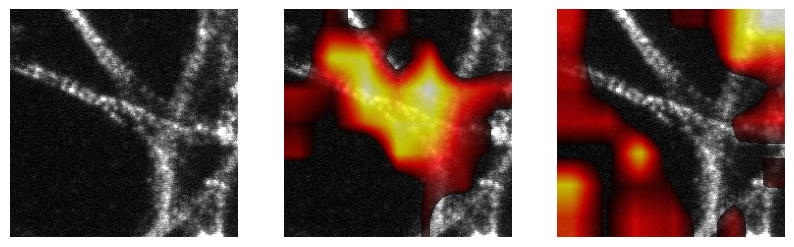

[1]
tensor(0.9108) tensor(0.9386)


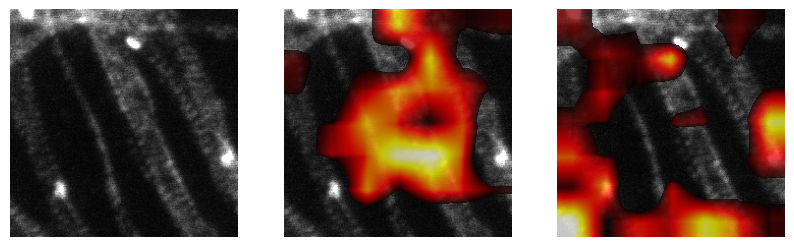

[2]
tensor(0.2915) tensor(0.3188)


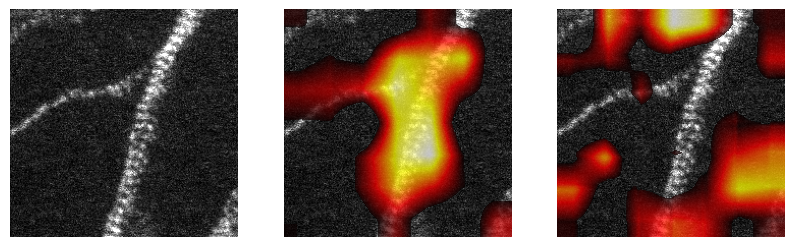

[3]
tensor(0.9245) tensor(0.9358)


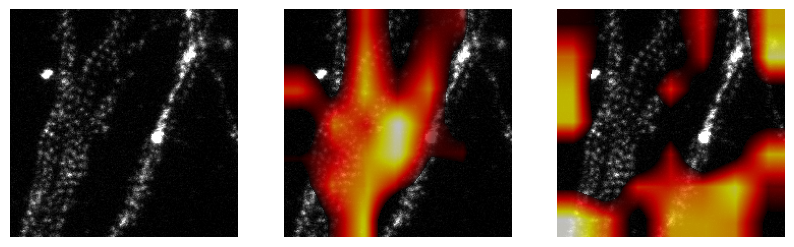

[4]
tensor(0.3666) tensor(0.4096)


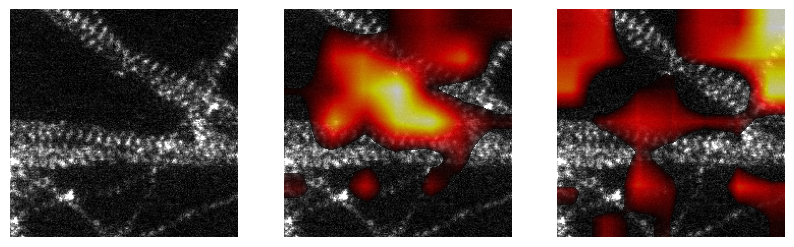

In [76]:

for data in relax_list:
    relax = data["relax"]
    idx = data["dataset-idx"].cpu().data.numpy()

    fig, axes = pyplot.subplots(1, 3, figsize=(10, 3))
    axes[0].imshow(relax.x[0, 0], vmin=0, vmax=numpy.quantile(relax.x[0, 0], 0.995), cmap="gray")
    axes[1].imshow(relax.x[0, 0], vmin=0, vmax=numpy.quantile(relax.x[0, 0], 0.995), cmap="gray")
    masked_importance = relax.importance().cpu().data.numpy()
    masked_importance[masked_importance < numpy.median(masked_importance)] = numpy.nan
    axes[1].imshow(relax.importance(), cmap="hot", alpha=0.75)
    axes[2].imshow(relax.x[0, 0], vmin=0, vmax=numpy.quantile(relax.x[0, 0], 0.995), cmap="gray")    
    masked_uncertainty = relax.uncertainty().cpu().data.numpy()
    masked_uncertainty[masked_uncertainty < numpy.median(masked_uncertainty)] = numpy.nan
    axes[2].imshow(masked_uncertainty, cmap="hot", alpha=0.75)    
    for ax in axes.ravel():
        ax.axis("off")
    pyplot.show()